# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import product  # Import product for grid search

In [3]:
def organise_data(strain_rates, temps):
    ref_temp = '298.15'
    for temp in temps:
        # Initialize DataFrame with strain column for the current temperature
        df = None  # Initialize df to None to handle it dynamically for each temperature
        
        for strain_rate in strain_rates:
            # Load stress data for the current temperature and strain rate
            data_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')
            
            if df is None:
                # Initialize DataFrame with strain column if not already done
                df = pd.DataFrame({'strain': data_RD['Strain']})
            
            # Add stress data for the current strain rate as a new column
            df[f'StrRt{strain_rate}'] = data_RD['Stress']

        # Filter the DataFrame for strain values below 0.08
        df = df[df['strain'] < 0.08]
        
        # Save the DataFrame to a CSV file for the current temperature
        output_file_path = f"Tmp{temp}_RD.csv"
        df.to_csv(output_file_path, index=False)

In [4]:
#First set, not necessary
strain_rates = [0.0001]
temps = ['77.15', '233.15']
organise_data(strain_rates, temps)

#Second set
strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['373.15', '473.15', '573.15', '673.15']
organise_data(strain_rates, temps)

#Third set
strain_rates = [0.0001, 0.001, 0.01, 0.1,1]
temps = ['298.15']
organise_data(strain_rates, temps)

# Find parameters for strain rate function


In [5]:
def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, C1, C2, R_squared for each row in the dataset.
    """
    # Load the temperature-specific file
    data = pd.read_csv(f"{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = [3, 4, 5, 6, 11]
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1e8

    # Define the strain-rate dependency function
    def strain_rate_dependent_stress(strain_rate, C1, C2, stress_values):
        return np.array([s * (C1 * np.log(sr) + C2) for s, sr in zip(stress_values, strain_rate)])

    # List to store the results
    results = []

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract stress data for the specified strain rates at row `i`
        stress_values = data.iloc[i][strain_rate_columns].values  # Select specified strain rate columns
        plastic_strain = data['strain'].iloc[i]  # Get the plastic strain at this row (PEEQ)

        # Fit strain-rate dependency with evolving stress values
        initial_guess_sr = [0.1, 1]  # Adjusted initial guesses
        bounds_sr = ([0, 0], [np.inf, np.inf])  # Tighter bounds to avoid non-physical values
        
        # Perform the curve fitting for strain-rate dependency using evolving stress values
        try:
            params_sr, _ = curve_fit(lambda sr, C1, C2: strain_rate_dependent_stress(sr, C1, C2, stress_values),
                                     strain_rates, stress_values, p0=initial_guess_sr, bounds=bounds_sr)
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Calculate residuals for error estimation
        stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr, stress_values)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": plastic_strain,
            "C1": params_sr[0],
            "C2": params_sr[1],
            "R_squared": r_squared
        })
        
        # Plot only for specified rows with scaled C1 and C2 in legend
        if i in plot_indices:
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(strain_rates, stress_fit, '-', label='Fit')  # Use only original strain rates for fit plot
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: C1={params_sr[0] * scale_factor:.2f} x 1e-8, C2={params_sr[1] * scale_factor:.2f} x 1e-8'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}.csv", index=False)


## RT

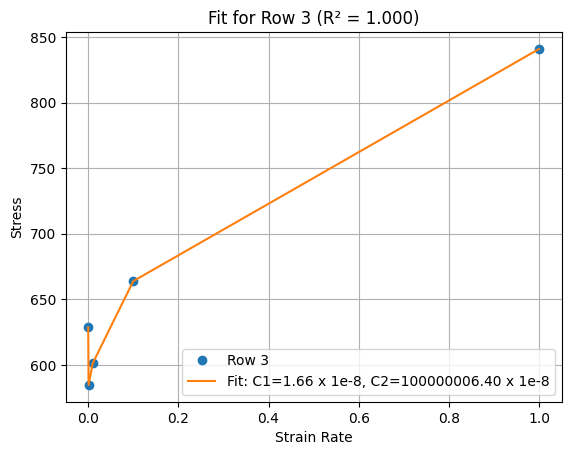

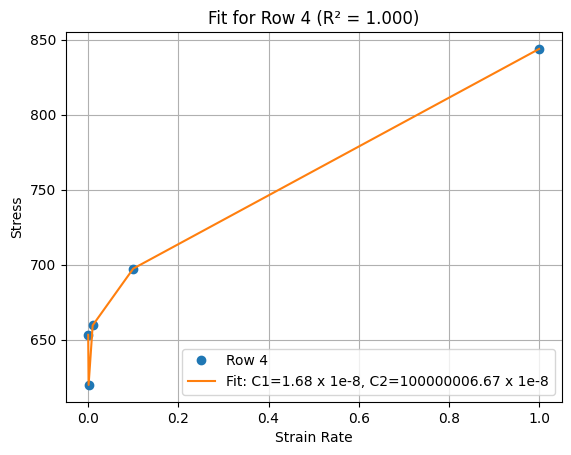

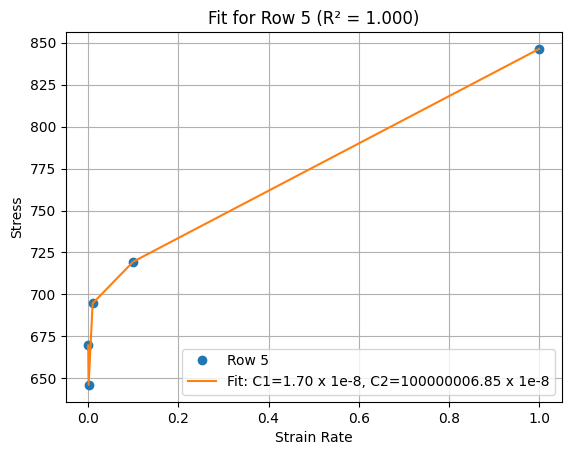

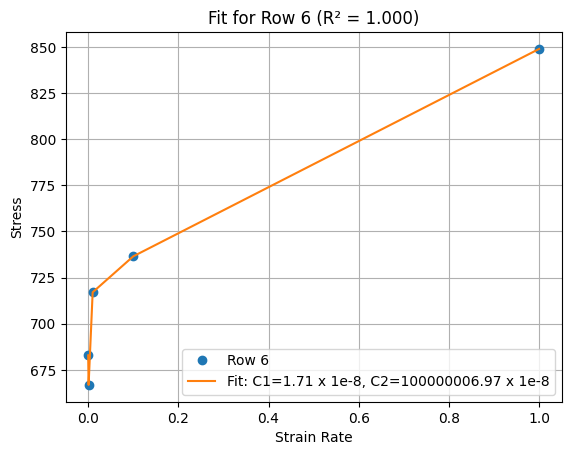

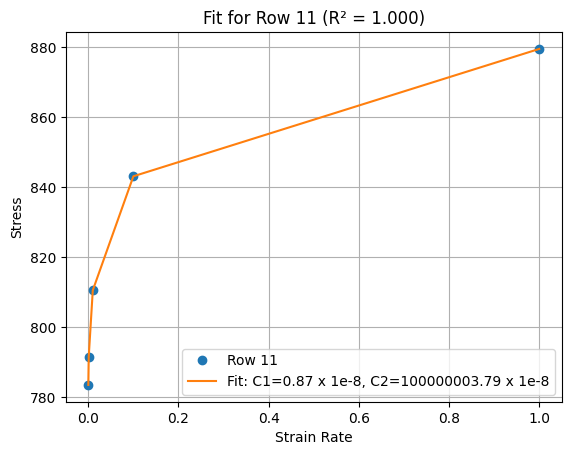

In [6]:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['StrRt0.0001', 'StrRt0.001', 'StrRt0.01', 'StrRt0.1', 'StrRt1']

fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

## Other cases

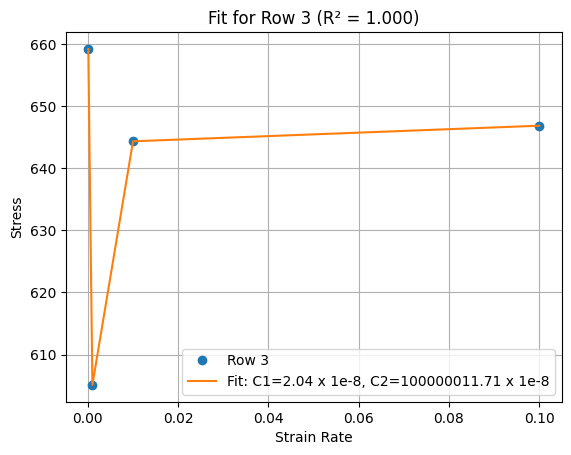

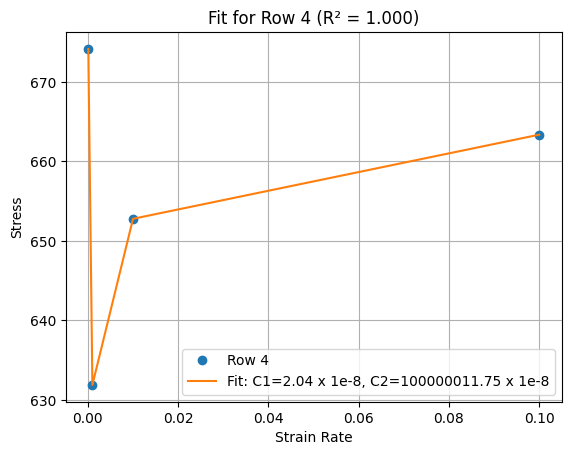

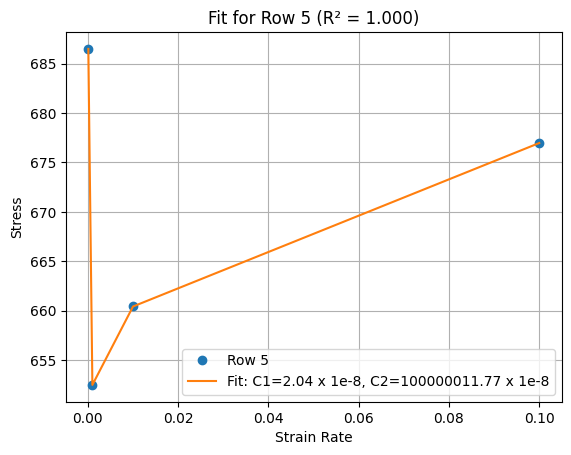

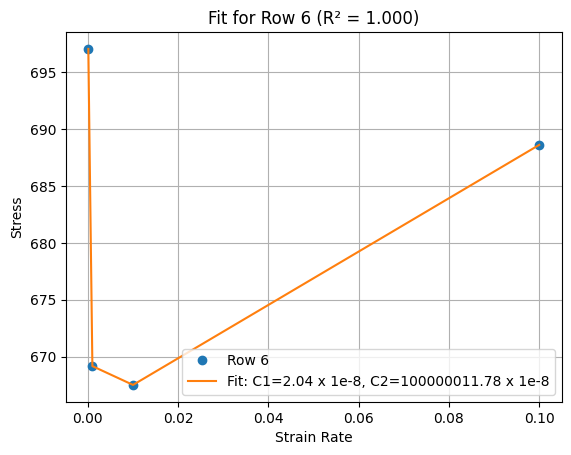

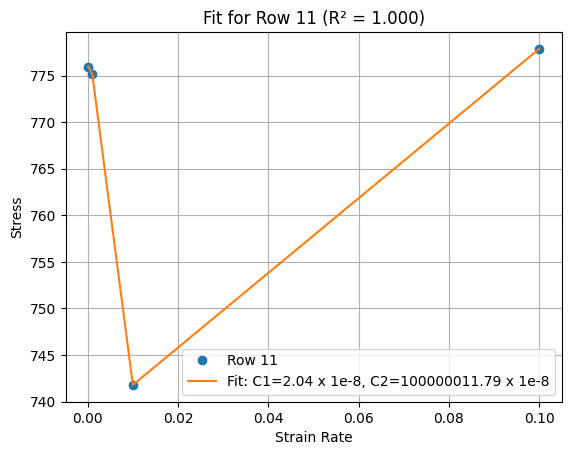

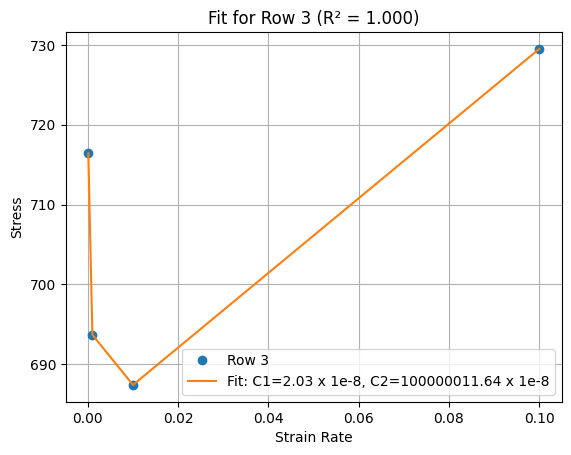

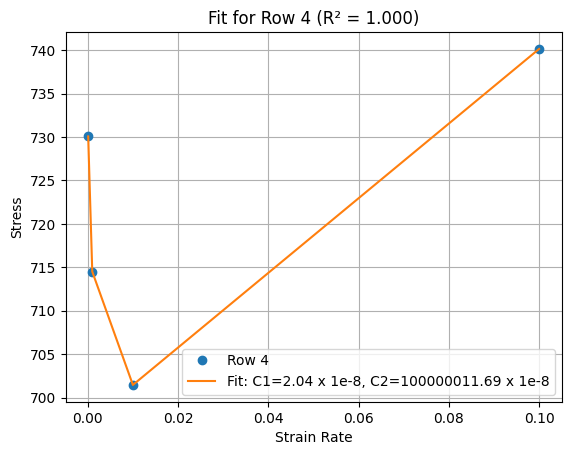

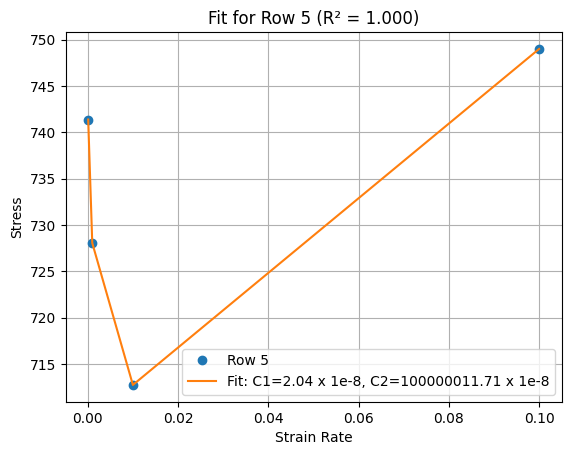

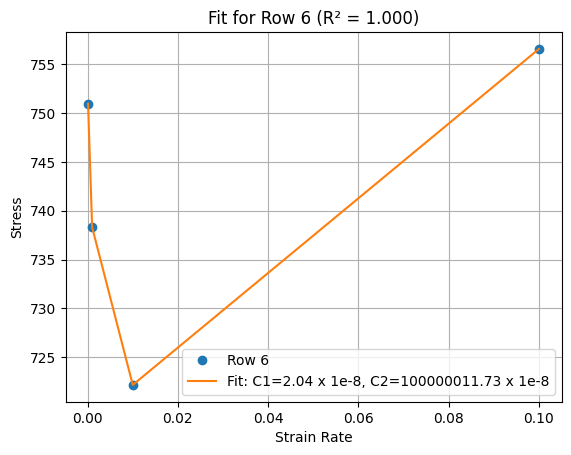

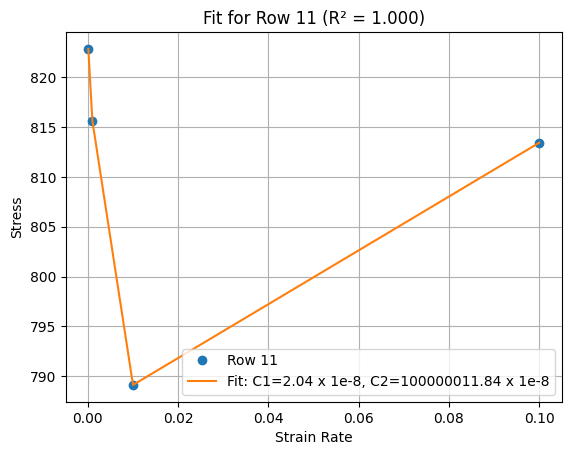

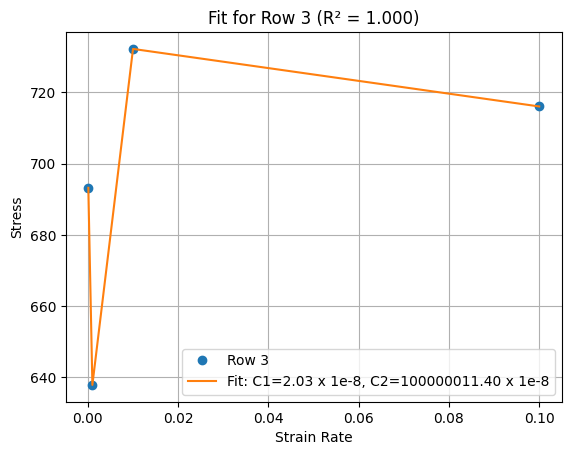

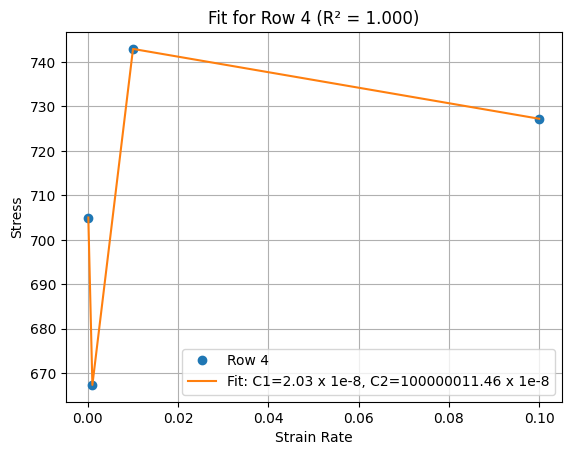

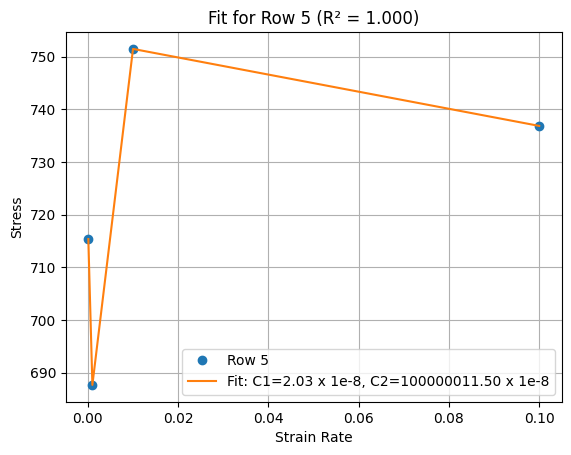

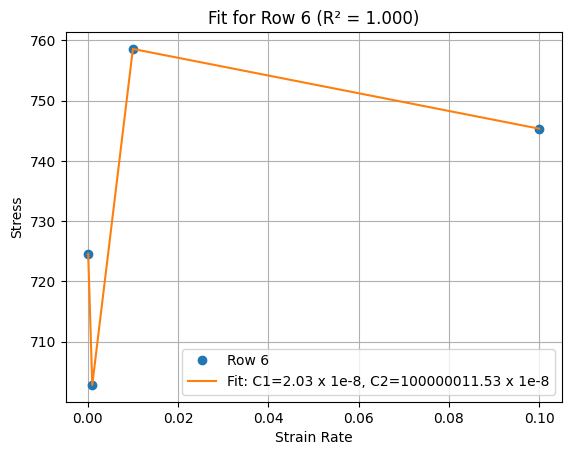

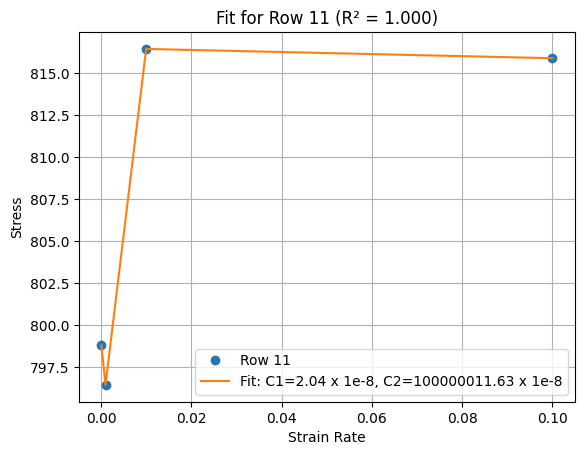

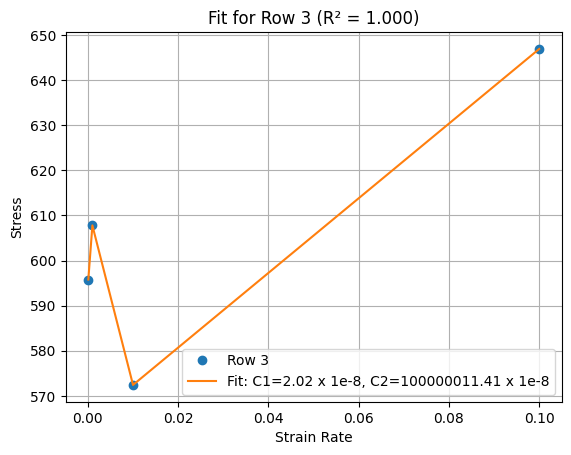

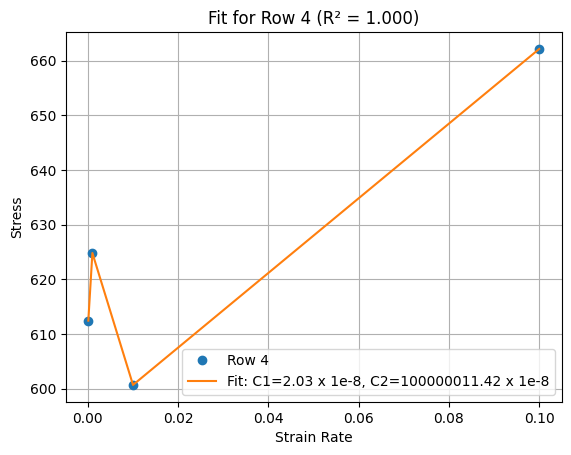

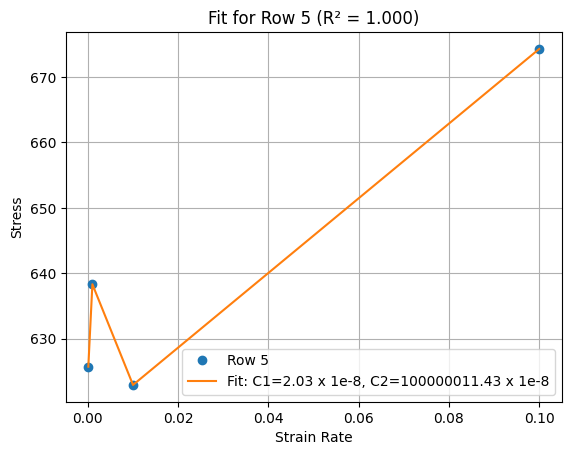

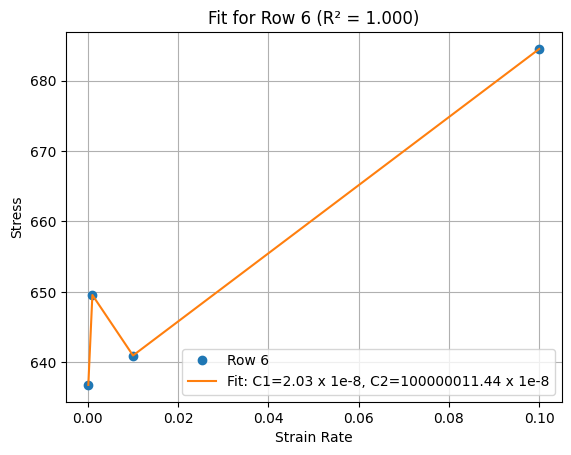

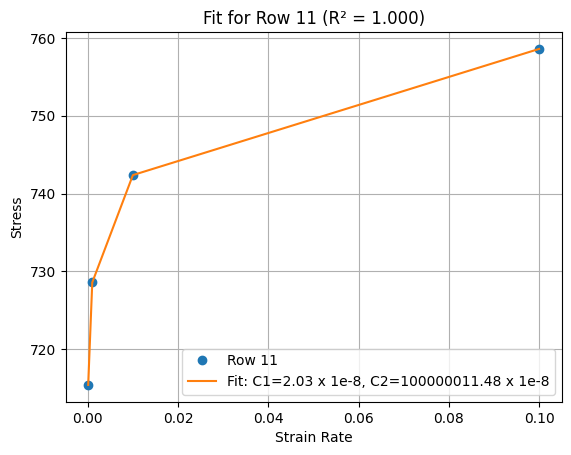

In [7]:
temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['StrRt0.0001', 'StrRt0.001', 'StrRt0.01', 'StrRt0.1']

for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

# Check R1 score
## Check to see if any R1 < 0.998

In [8]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports any below 0.99.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints any rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.999
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}.csv")
        
        # Filter rows where R_squared is less than 0.99
        low_r_squared = df[df['R_squared'] < threshold]
        
        if not low_r_squared.empty:
            print(f"\nTemperature File: Parameters_{temp_file}.csv")
            print(f"Rows with R_squared < {threshold}:")
            print(low_r_squared[['PEEQ', 'C1', 'C2', 'R_squared']])
        else:
            print(f"\nTemperature File: Parameters_{temp_file}.csv")
            print(f"All R_squared values are >= {threshold}.")

#Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp373.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp473.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp573.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp673.15_RD.csv
All R_squared values are >= 0.999.


# Calibrate C1, C2 based on strain dependent

## Study relationship between C1, C2
C1, C2 follows the same trend for a condition and is dependent on strain rate => Use the same strain dependent function

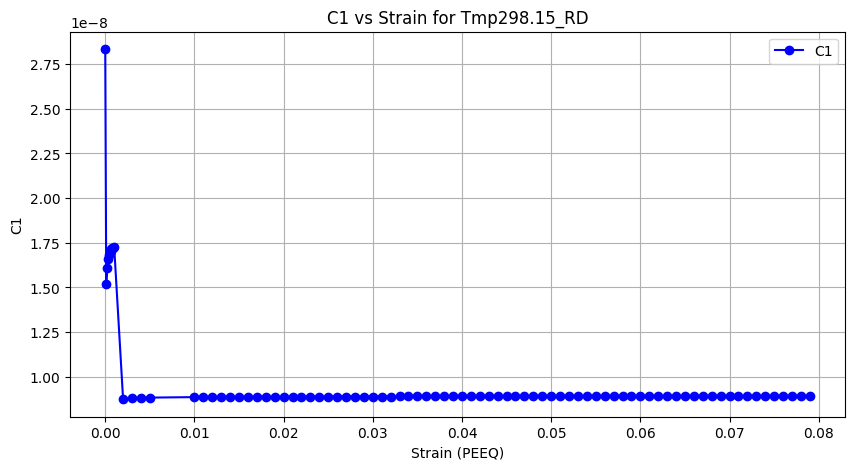

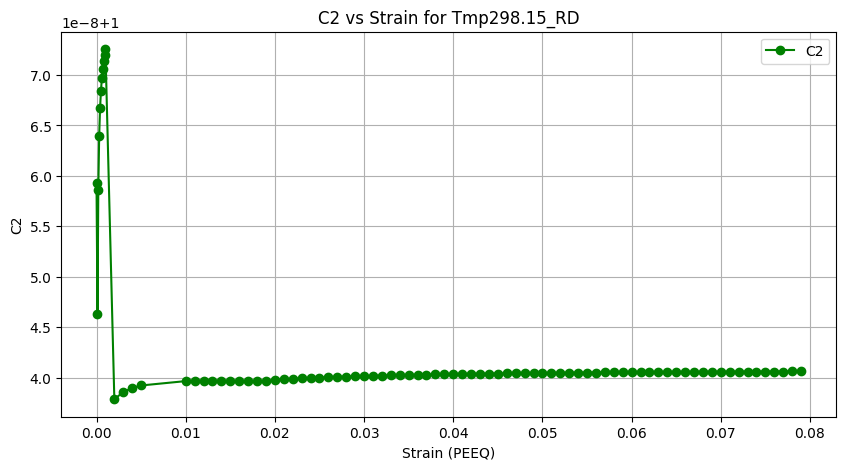

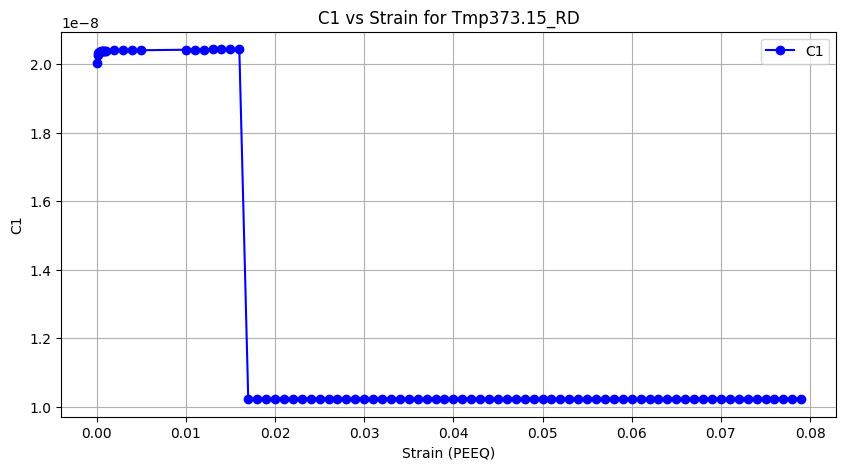

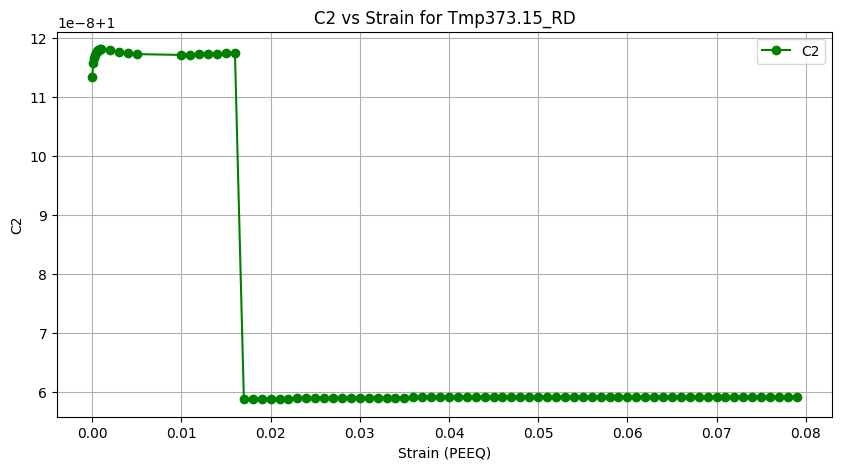

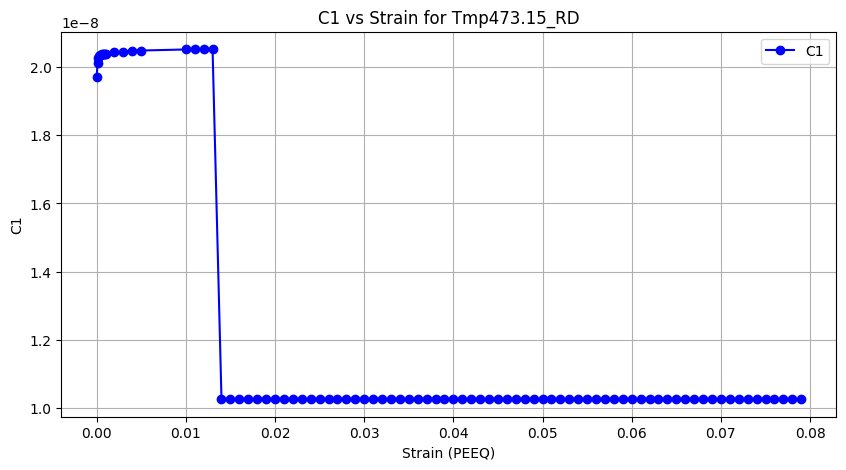

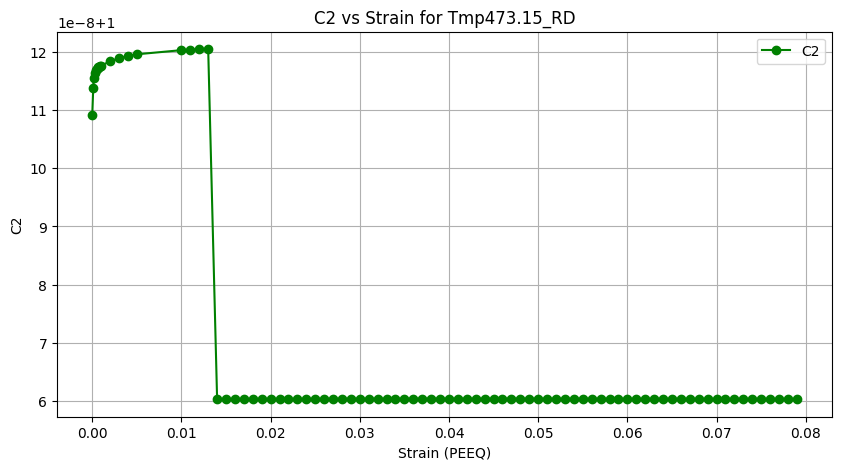

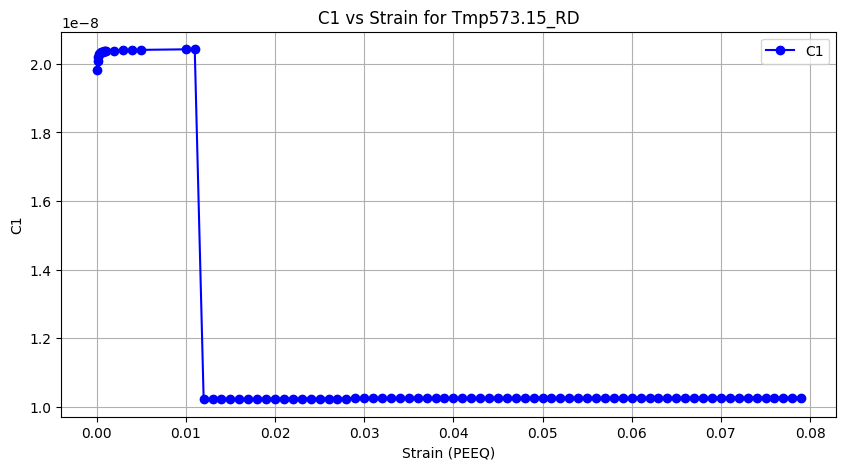

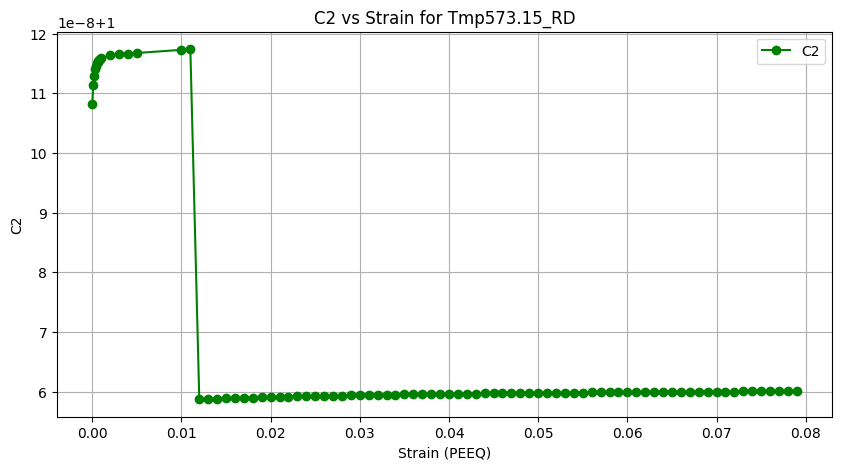

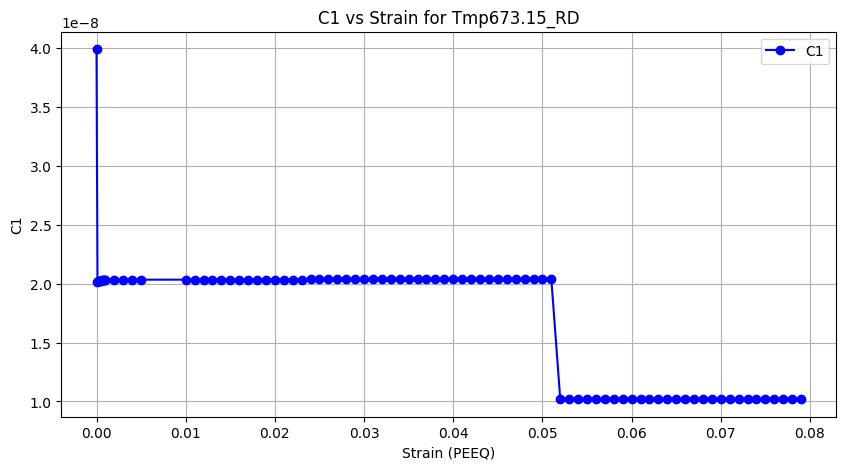

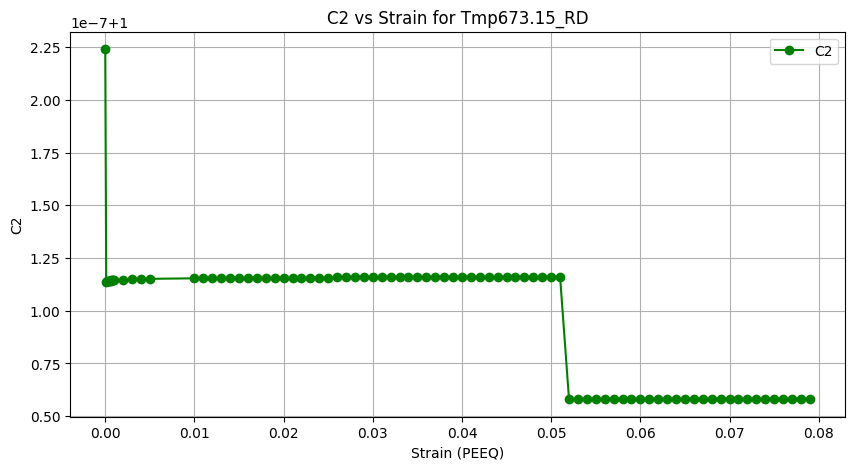

In [21]:
# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}.csv")
    
    # Plot C1 vs. strain with lines
    plt.figure(figsize=(10, 5))
    plt.plot(df['PEEQ'], df['C1'], marker='o', color='blue', label='C1')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.title(f"C1 vs Strain for {temp_file}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot C2 vs. strain with lines
    plt.figure(figsize=(10, 5))
    plt.plot(df['PEEQ'], df['C2'], marker='o', color='green', label='C2')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.title(f"C2 vs Strain for {temp_file}")
    plt.legend()
    plt.grid()
    plt.show()


## Calibrate strain dependent function for C1 and C2

In [43]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values

    # Define the stretched exponential model
    def stretched_exponential(epsilon, a, b, c, d):
        return a * np.exp(-b * epsilon**c) + d

    # Initial guesses for C1
    initial_guess_C1 = [2.0, 10, 0.5, 0.9]

    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(stretched_exponential, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)

    # Generate strain values for fitting curves
    strain_fit = np.linspace(min(strain), max(strain), 100)

    # Grid search for the best initial guess for C2 parameters
    # Define small ranges around a reasonable starting point for each parameter
    a_range = np.linspace(1.0, 3.0, 10)      # Wider range for a
    b_range = np.linspace(5, 15, 10)         # Wider range for b
    c_range = np.linspace(0.3, 0.7, 10)      # Wider range for c
    d_range = np.linspace(0.8, 1.2, 10)      # Wider range for d

    best_params_C2 = None
    best_r2_C2 = -np.inf

    # Perform grid search over the parameter ranges
    for a, b, c, d in product(a_range, b_range, c_range, d_range):
        try:
            popt_C2, _ = curve_fit(stretched_exponential, strain, C2_values, p0=[a, b, c, d], maxfev=10000000)
            C2_fitted_values = stretched_exponential(strain, *popt_C2)
            r2_C2 = r2_score(C2_values, C2_fitted_values)
            if r2_C2 > best_r2_C2:
                best_r2_C2 = r2_C2
                best_params_C2 = popt_C2
        except RuntimeError:
            continue

    # Use the best parameters found for C2
    popt_C2 = best_params_C2

    # Generate fitted values using the stretched exponential model
    C1_fit = stretched_exponential(strain_fit, *popt_C1)
    C2_fit = stretched_exponential(strain_fit, *popt_C2)

    # Calculate the fitted values at the original strain points for R^2 score calculation
    C1_fitted_values = stretched_exponential(strain, *popt_C1)
    C2_fitted_values = stretched_exponential(strain, *popt_C2)

    # Calculate R^2 scores
    r2_C1 = r2_score(C1_values, C1_fitted_values)

    # Plot C1 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain_fit, C1_fit, '-', label='C1 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C1:.3f})")
    plt.show()
    plt.savefig(f"results/C1_{temp_file}.png")

    # Plot C2 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain_fit, C2_fit, '-', label='C2 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {best_r2_C2:.3f})")
    plt.savefig(f"results/C2_{temp_file}.png")
    plt.show()

    # Print the fitted parameters for reference
    print("Stretched Exponential Fit Parameters for C1:", popt_C1)
    print("Best Stretched Exponential Fit Parameters for C2:", best_params_C2)
    print("Best R^2 for C2:", best_r2_C2)

# Example usage:
# calibrate_strain_dependent('Tmp673.15_RD')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could

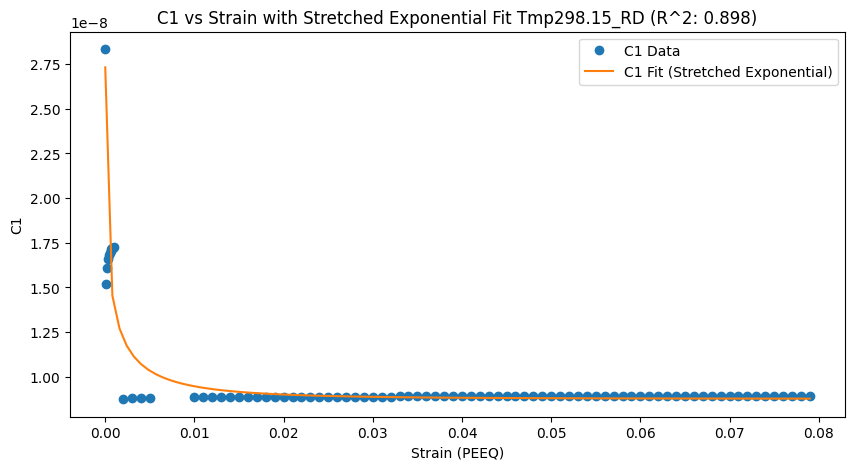

<Figure size 640x480 with 0 Axes>

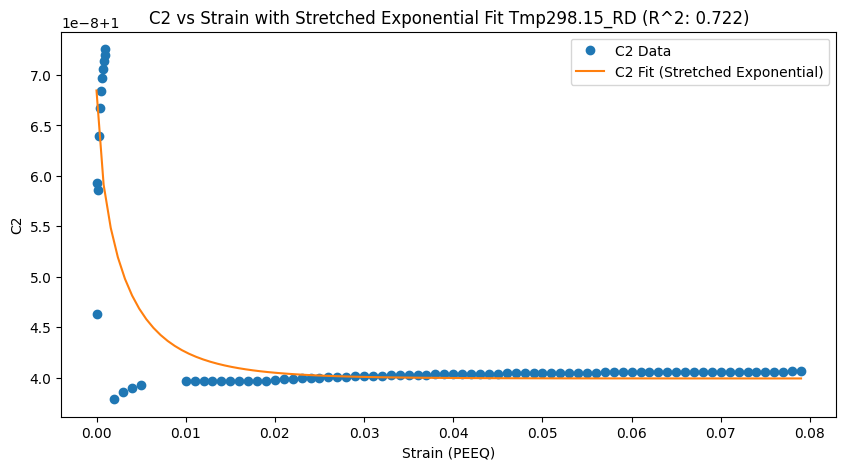

Stretched Exponential Fit Parameters for C1: [1.85478856e-08 2.14878456e+01 4.08332239e-01 8.76551457e-09]
Best Stretched Exponential Fit Parameters for C2: [2.85599188e-08 6.33748493e+01 7.11482800e-01 1.00000004e+00]
Best R^2 for C2: 0.7222662006658567


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.1

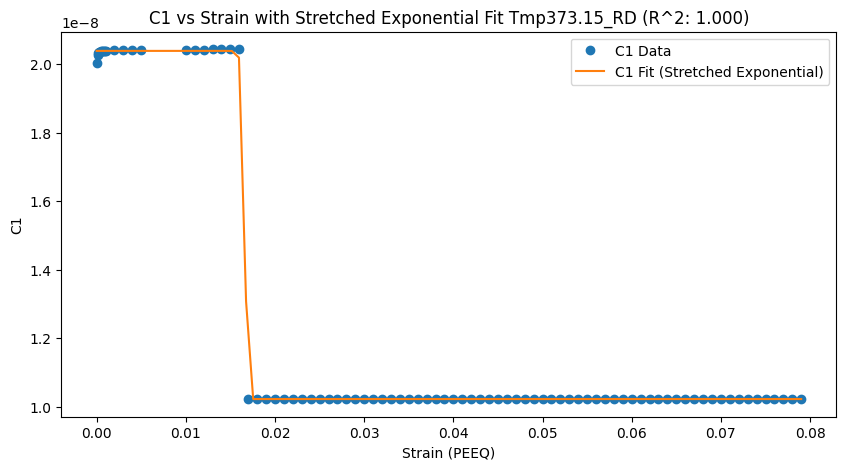

<Figure size 640x480 with 0 Axes>

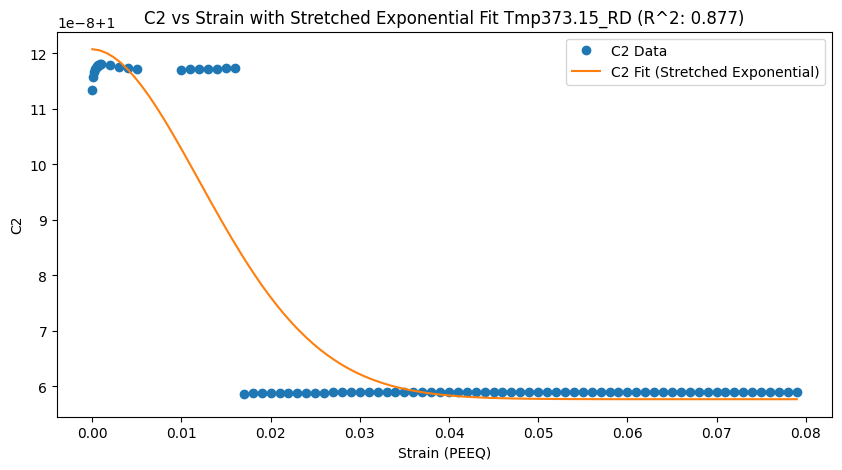

Stretched Exponential Fit Parameters for C1: [1.01733286e-008 1.19861793e+152 8.55811948e+001 1.02176444e-008]
Best Stretched Exponential Fit Parameters for C2: [6.30589591e-08 1.90697795e+03 1.87720219e+00 1.00000006e+00]
Best R^2 for C2: 0.8766807063588724


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.1

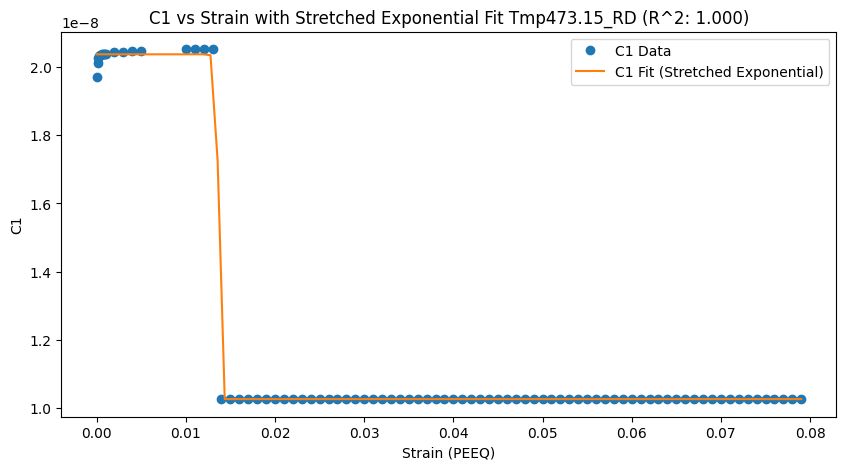

<Figure size 640x480 with 0 Axes>

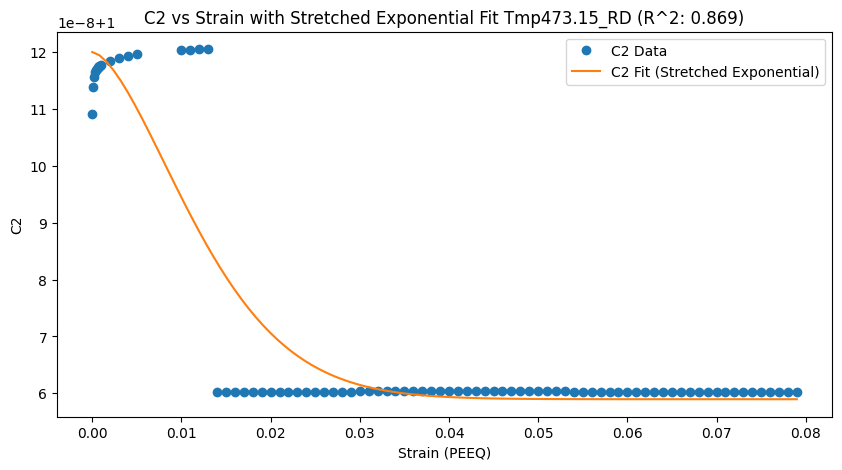

Stretched Exponential Fit Parameters for C1: [1.01130864e-008 1.11507528e+152 8.16476951e+001 1.02609960e-008]
Best Stretched Exponential Fit Parameters for C2: [6.10290280e-08 9.08802029e+02 1.61192759e+00 1.00000006e+00]
Best R^2 for C2: 0.8688254701508767


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could

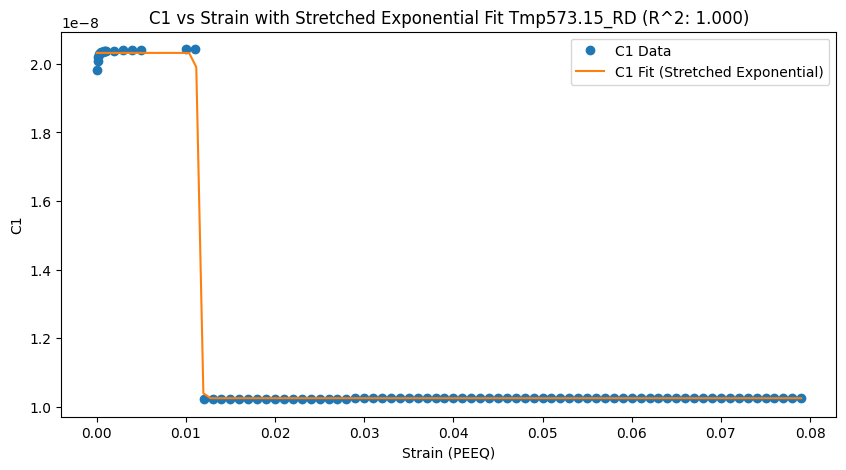

<Figure size 640x480 with 0 Axes>

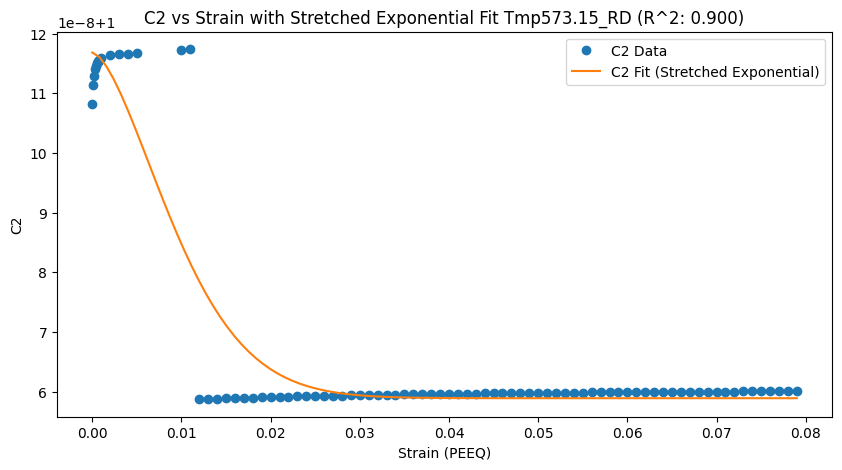

Stretched Exponential Fit Parameters for C1: [1.00759288e-008 2.75751813e+129 6.70220191e+001 1.02459104e-008]
Best Stretched Exponential Fit Parameters for C2: [5.79176500e-08 1.39167746e+03 1.61824434e+00 1.00000006e+00]
Best R^2 for C2: 0.8997917516929005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could

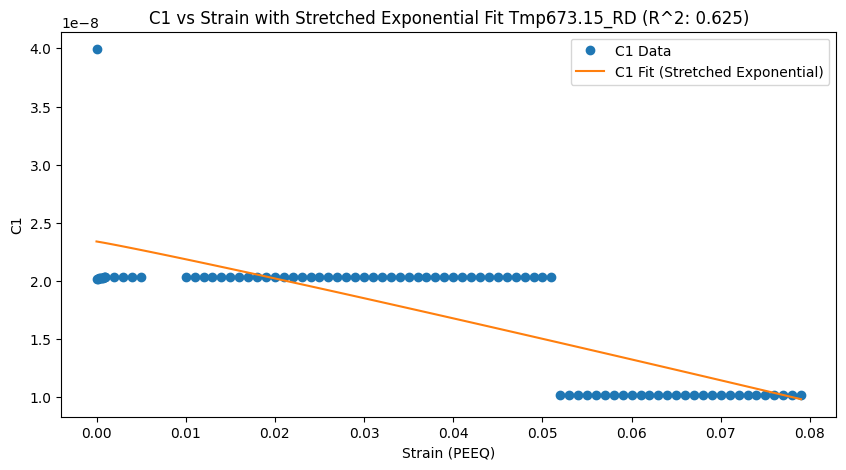

<Figure size 640x480 with 0 Axes>

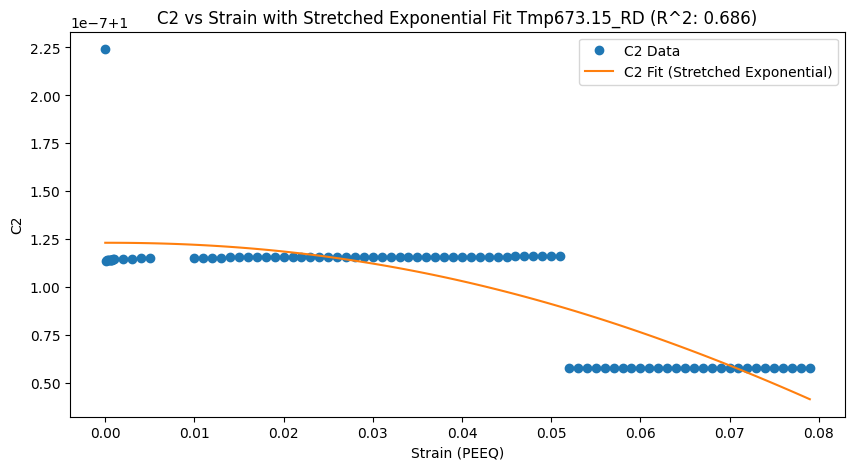

Stretched Exponential Fit Parameters for C1: [ 3.14248936e-02  6.29880084e-06  1.05611275e+00 -3.14248702e-02]
Best Stretched Exponential Fit Parameters for C2: [5.94436324e-07 3.44949406e+01 2.14876129e+00 9.99999529e-01]
Best R^2 for C2: 0.6859290526332873


In [44]:
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

# Bonus

Temperature dependence and normalized stress

In [13]:
'''
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15', '298.15', '373.15', '473.15', '573.15', '673.15']

#Second set
strain_rates = [0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

for strain_rate in strain_rates:
    # Load reference stress data at 298.15 K for the given strain rate
    data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    ref_stress_RD = data_RD_ref['Stress']  # Stress column at reference temperature
    
    # Initialize DataFrame with strain column
    df = pd.DataFrame({'strain': data_RD_ref['Strain']})
    
    # Loop over each temperature to calculate and add normalized stress columns
    for temp in temps:
        # Load stress data at the current temperature
        temp_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        # Calculate normalized stress by dividing by reference stress at 298.15 K
        normalized_stress_RD = temp_RD / ref_stress_RD
        
        # Add normalized stress as a column in the DataFrame
        df[f'Tmp{temp}K_ref'] = normalized_stress_RD

    # Save the DataFrame to a CSV file
    df = df[df['strain'] < 0.08]
    output_file_path = f"StrainRate{strain_rate}_RD.csv"
    df.to_csv(output_file_path, index=False)
'''

'''
def organise_data_normalized(strain_rates, temps):
    ref_temp = '298.15'
    
    # Loop over each temperature
    for temp in temps:
        df = None  # Initialize df to None to handle it dynamically for each temperature
        
        for strain_rate in strain_rates:
            # Load reference stress data at 298.15 K for the given strain rate
            data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
            ref_stress_RD = data_RD_ref['Stress']
            
            # Load current temperature stress data for the given strain rate
            data_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')
            
            # Calculate normalized stress
            normalized_stress_RD = data_RD['Stress'] / ref_stress_RD
            
            if df is None:
                # Initialize DataFrame with strain column if not already done
                df = pd.DataFrame({'strain': data_RD['Strain']})
            
            # Add normalized stress data for the current strain rate as a new column
            df[f'StrRt{strain_rate}'] = normalized_stress_RD

        # Filter the DataFrame for strain values below 0.08
        df = df[df['strain'] < 0.08]
        
        # Save the DataFrame to a CSV file for the current temperature
        output_file_path = f"Tmp{temp}_RD_normalized.csv"
        df.to_csv(output_file_path, index=False)
'''

'\ndef organise_data_normalized(strain_rates, temps):\n    ref_temp = \'298.15\'\n    \n    # Loop over each temperature\n    for temp in temps:\n        df = None  # Initialize df to None to handle it dynamically for each temperature\n        \n        for strain_rate in strain_rates:\n            # Load reference stress data at 298.15 K for the given strain rate\n            data_RD_ref = pd.read_csv(f\'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv\')\n            ref_stress_RD = data_RD_ref[\'Stress\']\n            \n            # Load current temperature stress data for the given strain rate\n            data_RD = pd.read_csv(f\'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv\')\n            \n            # Calculate normalized stress\n            normalized_stress_RD = data_RD[\'Stress\'] / ref_stress_RD\n            \n            if df is None:\n                # Initialize DataFrame with strain column if not already done\n                df = pd.DataFrame({\'